# Proyek Sentiment Analysis: [Traveloka Review]
- **Nama:** [Aditiya Saputra]
- **Email:** [AditiyaS1811@gmail.com]
- **ID Dicoding:** [aditiya18]

# **Import Library**

In [1]:
pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download as nltk_download
nltk_download('punkt')
nltk_download('stopwords')
nltk_download('wordnet')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, Bidirectional, MaxPooling1D, Flatten, GRU, SimpleRNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import requests
import csv
from io import StringIO
import tensorflow as tf

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# **Load Dataset**

In [3]:
# Load dataset
data = pd.read_csv("traveloka_scraping_data.csv")

Lima Data Teratas

In [4]:
# Menampilkan lima data teratas.
data.head()

,userName,score,at,content
0,Pengguna Google,4,2024-10-12 17:57:46,masukan: buat semua kode voucher/diskon/promo ...
1,Pengguna Google,1,2024-08-30 05:45:22,"Harga yg tertera berubah ubah setiap detik, ti..."
2,Pengguna Google,3,2024-08-27 09:56:02,Semakin kesini semakin ga jelas kebijakan Trav...
3,Pengguna Google,1,2024-08-29 13:17:18,"Aplikasi sampah, saya barusan melakukan pesana..."
4,Pengguna Google,1,2024-10-22 05:37:52,Dengan banyak ulasan mengenai aplikasi ini say...


Info Dataset

In [5]:
# Menampilkan info dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  30000 non-null  object
 1   score     30000 non-null  int64 
 2   at        30000 non-null  object
 3   content   30000 non-null  object
dtypes: int64(1), object(3)
memory usage: 937.6+ KB


# **Data Preprocessing**

Missing Value

In [6]:
# Menghapus missing value pada kolom 'content'
clean_data = data.dropna(subset=['content'])

# Menghapus data duplikat
clean_data = clean_data.drop_duplicates()

1. cleaningText(text)

Tujuan: Membersihkan teks dari elemen yang tidak diperlukan.
Proses:
Menghapus mention (@username), hashtag (#hashtag), tautan, dan angka.
Menghapus tanda baca dan baris baru.
Menghilangkan spasi ekstra di awal dan akhir teks.
2. casefoldingText(text)

Tujuan: Mengubah semua huruf menjadi kecil.
Proses: Memudahkan pencocokan kata.
3. tokenizingText(text)

Tujuan: Memecah teks menjadi kata-kata (token).
Proses: Membantu analisis kata satu per satu.
4. filteringText(text)

Tujuan: Menghapus kata-kata umum (stopwords).
Proses: Menghasilkan daftar kata yang lebih relevan.
5. stemmingText(text)

Tujuan: Mengubah kata menjadi bentuk dasarnya.
Proses: Mengurangi variasi kata untuk analisis lebih sederhana.
6. toSentence(list_words)

Tujuan: Menggabungkan kata-kata menjadi kalimat.
Proses: Mengembalikan teks ke format yang lebih mudah dibaca.

In [7]:
# Mendefinisikan fungsi-fungsi untuk preprocessing text

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove numbers
    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()

    stemmed_words = [stemmer.stem(word) for word in words]

    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

Slangwords

In [8]:
# Mendefinisikan fungsi untuk slangwords

slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [9]:
# Menampilkan dataset yang belum dibersihkan
clean_df = clean_data
clean_df.head(1)

,userName,score,at,content
0,Pengguna Google,4,2024-10-12 17:57:46,masukan: buat semua kode voucher/diskon/promo ...


**Membersihkan Text**

In [10]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

## **Text setelah dibersihkan**

In [11]:
# Menampilkan dataset setelah preprocessing text
clean_df.head(1)

,userName,score,at,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,Pengguna Google,4,2024-10-12 17:57:46,masukan: buat semua kode voucher/diskon/promo ...,masukan buat semua kode voucherdiskonpromo dap...,masukan buat semua kode voucherdiskonpromo dap...,masukan buat semua kode voucherdiskonpromo dap...,"[masukan, buat, semua, kode, voucherdiskonprom...","[masukan, kode, voucherdiskonpromo, lihat, pil...",masukan kode voucherdiskonpromo lihat pilih me...


Lexicon positif dan negatif dari github

In [12]:
# Loads positive lexicon data from GitHub
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
reader = csv.reader(StringIO(response.text), delimiter=',')
for row in reader:
    lexicon_positive[row[0]] = int(row[1])


# Loads negative lexicon data from GitHub
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
reader = csv.reader(StringIO(response.text), delimiter=',')
for row in reader:
    lexicon_negative[row[0]] = int(row[1])

    # Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''

    if (score >= 0):
        polarity = 'positive'
    elif (score <= -7):
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

# **Pelabelan Pada Data**

In [13]:
# Memberi label pada text
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
positive    17194
neutral      8363
negative     4443
Name: count, dtype: int64


# **Data Understanding/Exploration**

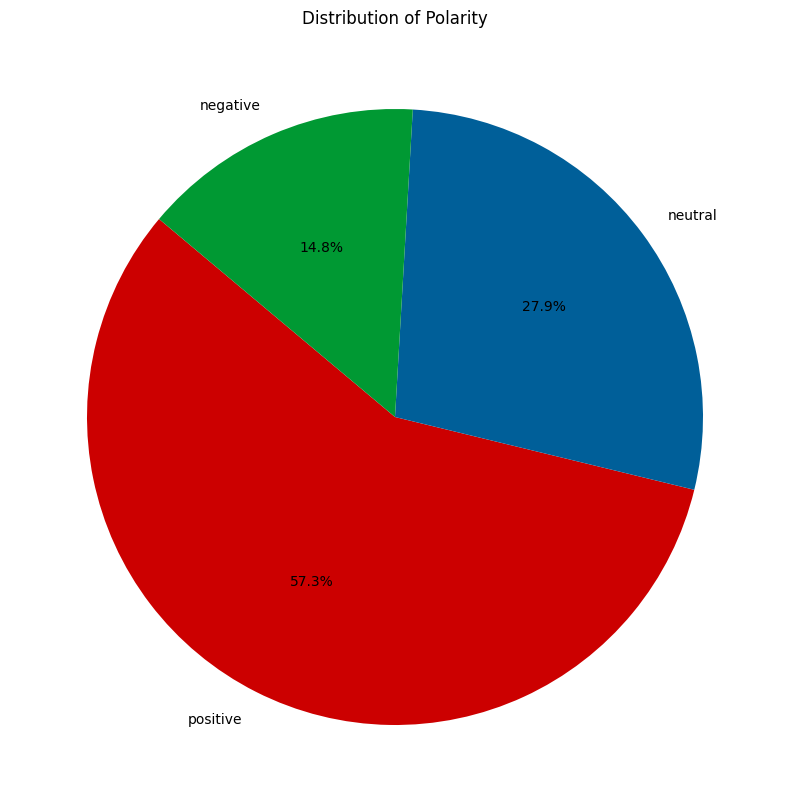

In [14]:
# Hitung jumlah masing-masing kategori polaritas
polarity_counts = clean_df['polarity'].value_counts()

# Menentukan warna-warna pie chart
colors = ['#cc0000', '#005f99', '#009933', '#996600']

# Menampilkan diagram lingkaran
plt.figure(figsize=(10, 10))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of Polarity')
plt.show()


**Word Cloud Keseluruhan dari Dataset**

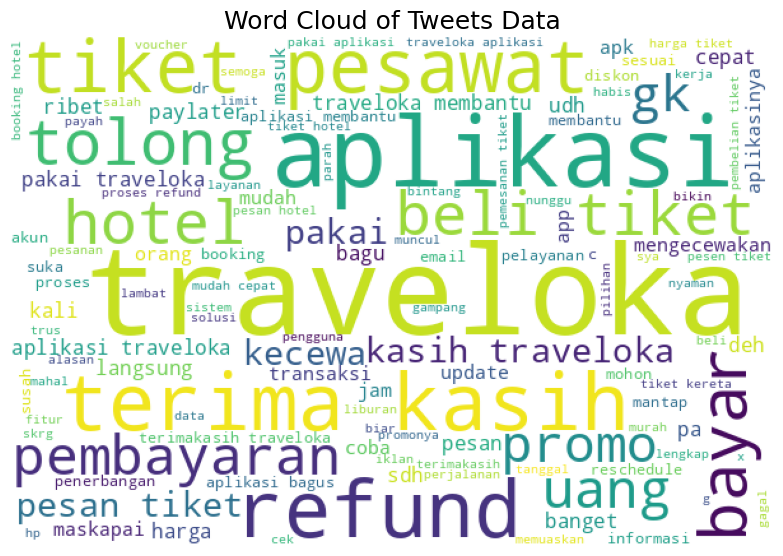

In [15]:
list_words = ''

for tweet in clean_df['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

**Word Cloud Positif**

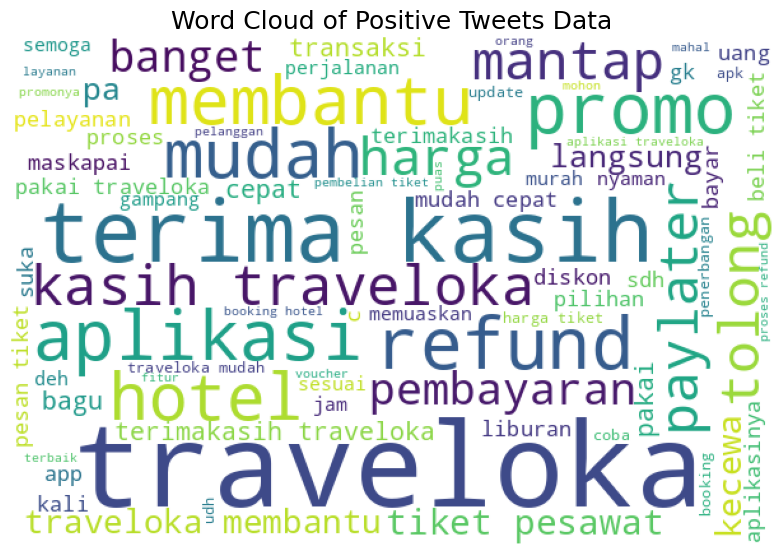

In [16]:
# Membuat dataframe untuk wordcloud positive
pd.set_option('display.max_colwidth', 2000)

positive_tweets = clean_df[clean_df['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)
positive_tweets = positive_tweets.reset_index(drop=True)
positive_tweets.index += 1

list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'positive_tweets'.
for tweet in positive_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Positive Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

**Word Cloud Negatif**

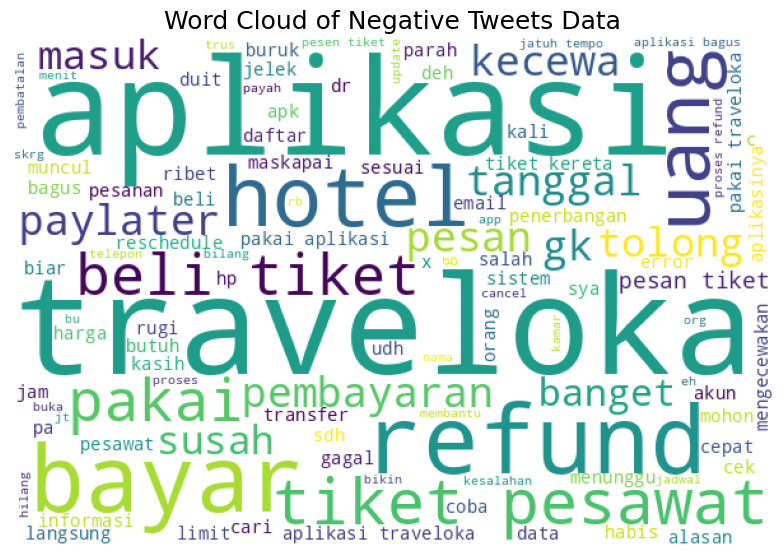

In [17]:
# Membuat dataframe untuk wordcloud negative
pd.set_option('display.max_colwidth', 2000)

negative_tweets = clean_df[clean_df['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=False)
negative_tweets = negative_tweets.reset_index(drop=True)
negative_tweets.index += 1

list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'negative_tweets'.
for tweet in negative_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Negative Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

**Word Cloud Netral**

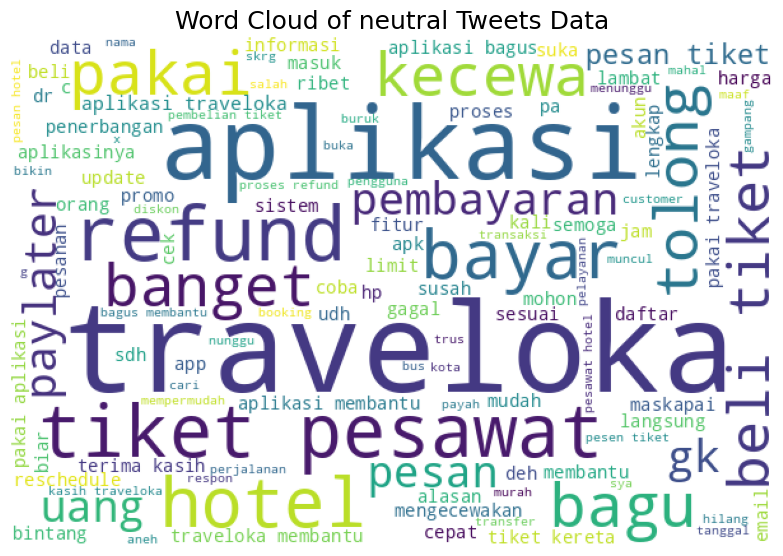

In [18]:
# Membuat dataframe untuk wordcloud neutral
pd.set_option('display.max_colwidth', 3000)

neutral_tweets = clean_df[clean_df['polarity'] == 'neutral']
neutral_tweets = neutral_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
neutral_tweets = neutral_tweets.sort_values(by='polarity_score', ascending=False)
neutral_tweets = neutral_tweets.reset_index(drop=True)
neutral_tweets.index += 1

list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'neutral_tweets'.
for tweet in neutral_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of neutral Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

# **Hasil Visualisasi Dataset**

**Kata Yang Sering Muncul**

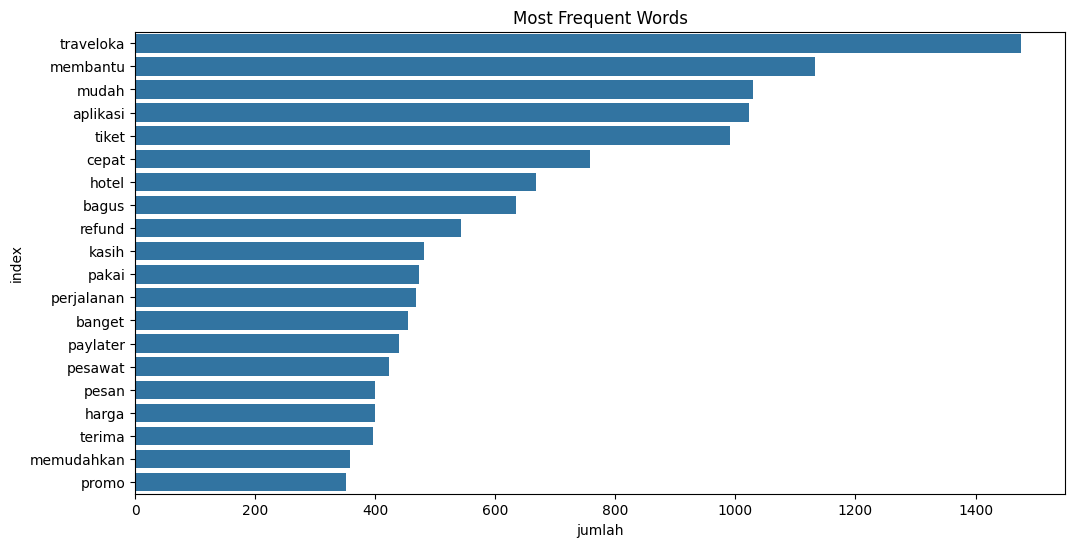

In [19]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Visualize most frequent words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

# **Modeling Untuk Sentiment Analysis**

In [20]:
# Mengambil kolom text_akhir dan polarity
X = clean_df['text_akhir']
y = clean_df['polarity']

Tokenisasi

In [21]:
# Tokenisasi
max_features = 3000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)

# Label encoding
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(y)
y = to_categorical(integer_encoded)

# Menentukan jumlah kelas
num_classes = y.shape[1]

# **Model 1**


*   **Algoritma Pelatihan: LSTM **
*   Pembagian Dataset Awal:

Data dibagi menjadi 90% untuk pelatihan dan validasi (X_train_val) serta 10% untuk pengujian (X_test_LSTM).
Menggunakan train_test_split dengan parameter untuk mengontrol ukuran dan replikasi hasil.

*   Pembagian Data Latih dan Validasi:

Dari data latih dan validasi (X_train_val), sekitar 10% dari total data (atau 1/9) digunakan sebagai data validasi (X_val_LSTM).
Sisa 80% dari total data digunakan sebagai data latih (X_train_LSTM).



In [24]:
# Memisahkan data latih, validasi, dan uji untuk model LSTM
X_train_val, X_test_LSTM, y_train_val, y_test_LSTM = train_test_split(X, y, test_size=0.1, random_state=42)

# Memisahkan data latih dan validasi untuk model LSTM
X_train_LSTM, X_val_LSTM, y_train_LSTM, y_val_LSTM = train_test_split(X_train_val, y_train_val, test_size=1/9, random_state=42)


**Membangun Model LSTM**
Model Sequential: Menggunakan Sequential() untuk membangun model bertingkat.
Lapisan Embedding:
Mengonversi kata menjadi vektor dengan max_features dan dimensi 256.
Menggunakan panjang input dari dataset.
Lapisan LSTM Pertama:
128 unit dengan dropout dan regularisasi L2 untuk mencegah overfitting.
Mengembalikan urutan penuh (return_sequences=True).
Lapisan LSTM Kedua:
64 unit dengan pengaturan dropout yang sama.
Hanya mengembalikan output terakhir.
Lapisan Dense:
Dua lapisan dense (128 dan 64 unit) dengan aktivasi ReLU untuk ekstraksi fitur.
Lapisan output dengan jumlah unit sesuai kelas dan aktivasi softmax.
Kompilasi Model:
Menggunakan categorical_crossentropy sebagai fungsi loss.
Optimizer Adam dengan laju pembelajaran 0.001.
Metrik evaluasi: akurasi.

In [25]:
# Membangun model LSTM
model_LSTM = Sequential()
model_LSTM.add(Embedding(max_features, 256, input_length=X.shape[1]))
model_LSTM.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), return_sequences=True))
model_LSTM.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
model_LSTM.add(Dense(128, activation='relu'))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dense(num_classes, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Melatih model dengan early stopping kustom
batch_size = 2056
history_LSTM = model_LSTM.fit(X_train_LSTM, y_train_LSTM, epochs=20, batch_size=batch_size, verbose=2,validation_data=(X_val_LSTM, y_val_LSTM))

Epoch 1/20
12/12 - 18s - 1s/step - accuracy: 0.5495 - loss: 5.3158 - val_accuracy: 0.5787 - val_loss: 4.3875
Epoch 2/20
12/12 - 5s - 457ms/step - accuracy: 0.5743 - loss: 3.8152 - val_accuracy: 0.5933 - val_loss: 3.1770
Epoch 3/20
12/12 - 12s - 974ms/step - accuracy: 0.6035 - loss: 2.7678 - val_accuracy: 0.6300 - val_loss: 2.3084
Epoch 4/20
12/12 - 10s - 850ms/step - accuracy: 0.6604 - loss: 1.9871 - val_accuracy: 0.7153 - val_loss: 1.6044
Epoch 5/20
12/12 - 11s - 935ms/step - accuracy: 0.7416 - loss: 1.4044 - val_accuracy: 0.7723 - val_loss: 1.1792
Epoch 6/20
12/12 - 8s - 656ms/step - accuracy: 0.7960 - loss: 1.0223 - val_accuracy: 0.8050 - val_loss: 0.8929
Epoch 7/20
12/12 - 10s - 848ms/step - accuracy: 0.8404 - loss: 0.7573 - val_accuracy: 0.8380 - val_loss: 0.6769
Epoch 8/20
12/12 - 7s - 580ms/step - accuracy: 0.8671 - loss: 0.5811 - val_accuracy: 0.8683 - val_loss: 0.5377
Epoch 9/20
12/12 - 9s - 737ms/step - accuracy: 0.8897 - loss: 0.4622 - val_accuracy: 0.8817 - val_loss: 0.4607

**Evaluasi Model CNN**

In [26]:
# Evaluasi model LSTM
score_LSTM, acc_LSTM = model_LSTM.evaluate(X_test_LSTM, y_test_LSTM, verbose=2, batch_size=512)
print("Test score: %.2f" % (score_LSTM))
print("Test accuracy: %.2f" % (acc_LSTM))


6/6 - 1s - 201ms/step - accuracy: 0.9120 - loss: 0.2930
Test score: 0.29
Test accuracy: 0.91


# **Model 2**

**Algoritma Pelatihan GRU**

*   Pembagian Awal:

Dataset dibagi menjadi 95% untuk pelatihan dan validasi (X_train_val) dan 5% untuk pengujian (X_test_GRU).
Fungsi train_test_split digunakan dengan test_size=0.05.

*   Pembagian Latih dan Validasi:

Dari data latih dan validasi (X_train_val), sekitar 5.26% dari total data (atau 0.0526) digunakan sebagai data validasi (X_val_GRU).
Sisa 89.74% digunakan sebagai data latih (X_train_GRU).

In [27]:
# Memisahkan data latih, validasi, dan uji
X_train_val, X_test_GRU, y_train_val, y_test_GRU = train_test_split(X, y, test_size=0.05, random_state=42)
X_train_GRU, X_val_GRU, y_train_GRU, y_val_GRU = train_test_split(X_train_val, y_train_val, test_size=0.0526, random_state=42)

**Membangun Model GRU**
Inisialisasi Model:

Model dibuat menggunakan Sequential().
Layer Embedding:

Embedding(max_features, 512, input_length=X.shape[1]): Mengonversi kata-kata menjadi vektor berdimensi 512.
Dropout:

SpatialDropout1D(0.3): Menerapkan dropout untuk mengurangi overfitting.
Layer GRU:

Bidirectional(GRU(64, return_sequences=True)): Menggunakan GRU dalam arah dua untuk menangkap konteks dari kedua arah dengan output berurutan.
Bidirectional(GRU(128, return_sequences=False)): Layer GRU kedua dengan 128 unit yang tidak mengembalikan output berurutan.
Layer Dense:

Dense(128, activation='relu', kernel_regularizer=l2(0.01)): Layer tersembunyi dengan 128 neuron dan regularisasi L2.
Dropout(0.5): Menerapkan dropout untuk mengurangi overfitting.
Dense(64, activation='relu', kernel_regularizer=l2(0.01)): Layer tersembunyi kedua dengan 64 neuron dan regularisasi L2.
Dropout(0.5): Dropout tambahan untuk regularisasi.
Dense(num_classes, activation='softmax'): Layer output dengan fungsi aktivasi softmax untuk klasifikasi.
Kompilasi Model:

Model dikompilasi menggunakan categorical_crossentropy sebagai loss function dan Adam sebagai optimizer dengan learning rate 0.001.
Melatih Model:

Model dilatih dengan fit(), menggunakan batch size 2056 dan validasi pada data validasi. Epoch ditetapkan ke 20.

In [28]:
# Membangun model GRU
model_GRU = Sequential()
model_GRU.add(Embedding(max_features, 512, input_length=X.shape[1]))
model_GRU.add(SpatialDropout1D(0.3))
model_GRU.add(Bidirectional(GRU(64, return_sequences=True)))
model_GRU.add(Bidirectional(GRU(128, return_sequences=False)))
model_GRU.add(Dense(128, activation='relu',kernel_regularizer=l2(0.01)))
model_GRU.add(Dropout(0.5))
model_GRU.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_GRU.add(Dropout(0.5))
model_GRU.add(Dense(num_classes, activation='softmax'))
model_GRU.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Melatih model dengan early stopping kustom
batch_size = 2056
history_GRU = model_GRU.fit(X_train_GRU, y_train_GRU, epochs=20, batch_size=batch_size, verbose=2, validation_data=(X_val_GRU, y_val_GRU))

Epoch 1/20
14/14 - 11s - 768ms/step - accuracy: 0.5534 - loss: 3.2277 - val_accuracy: 0.5913 - val_loss: 2.7131
Epoch 2/20
14/14 - 10s - 692ms/step - accuracy: 0.6390 - loss: 2.4439 - val_accuracy: 0.7253 - val_loss: 2.0187
Epoch 3/20
14/14 - 6s - 424ms/step - accuracy: 0.7498 - loss: 1.8053 - val_accuracy: 0.8313 - val_loss: 1.4602
Epoch 4/20
14/14 - 10s - 733ms/step - accuracy: 0.8403 - loss: 1.3272 - val_accuracy: 0.8613 - val_loss: 1.1196
Epoch 5/20
14/14 - 10s - 726ms/step - accuracy: 0.8897 - loss: 0.9930 - val_accuracy: 0.8520 - val_loss: 0.9668
Epoch 6/20
14/14 - 10s - 727ms/step - accuracy: 0.8980 - loss: 0.7954 - val_accuracy: 0.8860 - val_loss: 0.7319
Epoch 7/20
14/14 - 10s - 728ms/step - accuracy: 0.9260 - loss: 0.6170 - val_accuracy: 0.8927 - val_loss: 0.6269
Epoch 8/20
14/14 - 10s - 727ms/step - accuracy: 0.9355 - loss: 0.5002 - val_accuracy: 0.9060 - val_loss: 0.5255
Epoch 9/20
14/14 - 10s - 735ms/step - accuracy: 0.9446 - loss: 0.4095 - val_accuracy: 0.8933 - val_loss: 

In [29]:
# Evaluasi model
score_GRU, acc_GRU = model_GRU.evaluate(X_test_GRU, y_test_GRU, verbose=2)
print("Test score: %.2f" % (score_GRU))
print("Test accuracy: %.2f" % (acc_GRU))

47/47 - 1s - 13ms/step - accuracy: 0.9127 - loss: 0.3515
Test score: 0.35
Test accuracy: 0.91


Model 3

**Pelatihan Model CNN **

*   Pembagian Awal:

train_test_split membagi data menjadi:
X_train_val: 90% (data latih dan validasi)
X_test_CNN: 10% (data uji)
y_train_val: Label untuk data latih dan validasi
y_test_CNN: Label untuk data uji

*   Pembagian Data Latih dan Validasi:

train_test_split membagi X_train_val menjadi:
X_train_CNN: Data latih
X_val_CNN: Data validasi
y_train_CNN: Label untuk data latih
y_val_CNN: Label untuk data validasi

In [31]:
# Memisahkan data latih, validasi, dan uji untuk model CNN
X_train_val, X_test_CNN, y_train_val, y_test_CNN = train_test_split(X, y, test_size=0.1, random_state=42)

# Memisahkan data latih dan validasi untuk model CNN
X_train_CNN, X_val_CNN, y_train_CNN, y_val_CNN = train_test_split(X_train_val, y_train_val, test_size=2/9, random_state=42)


**Membangun Model CNN:**

Menggunakan Sequential() untuk membuat model.
Menambahkan layer:
Embedding: Menerjemahkan kata menjadi vektor berdimensi 256.
Conv1D: Dua layer konvolusi untuk ekstraksi fitur dengan ukuran kernel 3, diikuti oleh:
MaxPooling1D: Mengurangi dimensi untuk mengekstrak fitur penting.
Flatten: Mengubah output 2D menjadi 1D.
Dense: Dua layer fully connected untuk klasifikasi dengan aktivasi ReLU.
Layer terakhir dengan softmax untuk output kelas.

Kompilasi Model:
Menggunakan categorical_crossentropy sebagai loss function.
Menggunakan optimizer Adam dengan learning rate 0.001.
Menggunakan accuracy sebagai metrik evaluasi.

Melatih Model:
Menggunakan fit() dengan:
Data pelatihan (X_train_CNN, y_train_CNN).
20 epoch dan batch size 2056.
Mencatat kemajuan (verbose=2).
Data validasi (X_val_CNN, y_val_CNN).

In [32]:
# Membangun model CNN
model_CNN = Sequential()
model_CNN.add(Embedding(max_features, 256, input_length=X.shape[1]))
model_CNN.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Flatten())
model_CNN.add(Dense(128, activation='relu'))
model_CNN.add(Dense(64, activation='relu'))
model_CNN.add(Dense(num_classes, activation='softmax'))

# Kompilasi model CNN
model_CNN.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Melatih model CNN dengan early stopping kustom
batch_size = 2056
history_CNN = model_CNN.fit(
    X_train_CNN, y_train_CNN,
    epochs=20,
    batch_size=batch_size,
    verbose=2,
    validation_data=(X_val_CNN, y_val_CNN)
)

Epoch 1/20
11/11 - 11s - 1s/step - accuracy: 0.5496 - loss: 0.9876 - val_accuracy: 0.5793 - val_loss: 0.9364
Epoch 2/20
11/11 - 2s - 160ms/step - accuracy: 0.5731 - loss: 0.9157 - val_accuracy: 0.5817 - val_loss: 0.8684
Epoch 3/20
11/11 - 1s - 117ms/step - accuracy: 0.5995 - loss: 0.8218 - val_accuracy: 0.6635 - val_loss: 0.6975
Epoch 4/20
11/11 - 1s - 114ms/step - accuracy: 0.7420 - loss: 0.5992 - val_accuracy: 0.7833 - val_loss: 0.5141
Epoch 5/20
11/11 - 1s - 115ms/step - accuracy: 0.8367 - loss: 0.4032 - val_accuracy: 0.8468 - val_loss: 0.3878
Epoch 6/20
11/11 - 1s - 113ms/step - accuracy: 0.8956 - loss: 0.2782 - val_accuracy: 0.8673 - val_loss: 0.3457
Epoch 7/20
11/11 - 1s - 101ms/step - accuracy: 0.9237 - loss: 0.2098 - val_accuracy: 0.8823 - val_loss: 0.3152
Epoch 8/20
11/11 - 1s - 101ms/step - accuracy: 0.9441 - loss: 0.1626 - val_accuracy: 0.8932 - val_loss: 0.3090
Epoch 9/20
11/11 - 1s - 101ms/step - accuracy: 0.9574 - loss: 0.1332 - val_accuracy: 0.8985 - val_loss: 0.3115
Epo

In [33]:
# Evaluasi model CNN
score_CNN, acc_CNN = model_CNN.evaluate(X_test_CNN, y_test_CNN, verbose=2)
print("Test score: %.2f" % (score_CNN))
print("Test accuracy: %.2f" % (acc_CNN))

94/94 - 1s - 15ms/step - accuracy: 0.8953 - loss: 0.4579
Test score: 0.46
Test accuracy: 0.90


# **Evaluasi Model**

In [34]:
results_df = pd.DataFrame({
    'Model': ['CNN', 'GRU', 'LSTM'],
    'Accuracy Train': [history_CNN.history['accuracy'][-1],history_GRU.history['accuracy'][-1],history_LSTM.history['accuracy'][-1],],
    'Accuracy Test': [acc_CNN,acc_GRU,acc_LSTM]
})
results_df

,Model,Accuracy Train,Accuracy Test
0,CNN,0.995000,0.895333
1,GRU,0.978704,0.912667
2,LSTM,0.951958,0.912000


# Predict contoh **text**

In [51]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

# Fungsi untuk memprediksi label
def predict_sentiment(texts, model, tokenizer, maxlen, labelencoder):
    # Tokenisasi teks baru
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)

    # Membuat prediksi
    predictions = model.predict(padded_sequences)

    # Mengambil label prediksi
    predicted_labels = np.argmax(predictions, axis=1)

    # Mengonversi prediksi menjadi label asli
    predicted_labels = labelencoder.inverse_transform(predicted_labels)

    return predicted_labels

# Contoh data untuk diprediksi
new_texts = [
    "Akhirnya sudah di trima kembali uang refund. semoga traveloka bisa memantau hotel yang sudah tidak aktif lagi tidak masuk list di bookingan biar yang lain tidak repot juga pas holiday",
    "Dengan banyak ulasan mengenai aplikasi ini saya penguna baru ingin pesan tiket.uang pas2san jadi takut. refund kataya lama sedangkan saya butuh penerbangan di tgl 25.saya sudah pesen tapi mau bayar jadi ragu.saya chat di aplikasi emang resoon lambata.tidak ada chat wa atau chat yang membantu dengan cepat.",
    "terima kasih traveloka, sangat memudahkan dan membantu saya yg sering pergi ketempat tempat baru, jadi merasa nyaman dan aman karena Ada kamu traveloka "
]

# Memanggil fungsi prediksi
predicted_labels_LSTM = predict_sentiment(new_texts, model_LSTM, tokenizer, X.shape[1], labelencoder)
predicted_labels_CNN = predict_sentiment(new_texts, model_CNN, tokenizer, X.shape[1], labelencoder)
predicted_labels_GRU = predict_sentiment(new_texts, model_GRU, tokenizer, X.shape[1], labelencoder)

# Menampilkan hasil prediksi
for text, label_LSTM, label_CNN, label_GRU in zip(new_texts, predicted_labels_LSTM, predicted_labels_CNN, predicted_labels_GRU):
    print(f"Text: {text}\nPredicted Label (LSTM): {label_LSTM}\nPredicted Label (CNN): {label_CNN}\nPredicted Label (GRU): {label_GRU}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Text: Akhirnya sudah di trima kembali uang refund. semoga traveloka bisa memantau hotel yang sudah tidak aktif lagi tidak masuk list di bookingan biar yang lain tidak repot juga pas holiday
Predicted Label (LSTM): neutral
Predicted Label (CNN): neutral
Predicted Label (GRU): neutral

Text: Dengan banyak ulasan mengenai aplikasi ini saya penguna baru ingin pesan tiket.uang pas2san jadi takut. refund kataya lama sedangkan saya butuh penerbangan di tgl 25.saya sudah pesen tapi mau bayar jadi ragu.saya chat di aplikasi emang resoon lambata.tidak ada chat wa atau chat yang membantu dengan cepat.
Predicted Label (LSTM): negative
Predicted Label (CNN): negative
Predicted Label (GRU): negative

Text: terima kasih traveloka, sangat memudahkan dan membantu saya yg sering pergi ketempat tempat baru, jadi merasa nyaman dan aman karena Ada kamu traveloka 
Predicted Label (LSTM): positi